In [2]:
import pandas as pd
import numpy as np

import xgboost as xgb
import re
import matplotlib.pyplot as plt

#from tqdm.notebook import tqdm_notebook
from warnings import filterwarnings

%matplotlib inline
filterwarnings('ignore')

In [4]:
tr_mcc_codes = pd.read_csv('../data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('../data/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('../data/transactions.csv', index_col='customer_id')
transactions.describe()

,mcc_code,tr_type,amount
count,6.849346e+06,6.849346e+06,6.849346e+06
mean,5.589776e+03,2.517356e+03,-2.054285e+04
std,6.035857e+02,2.270108e+03,4.777528e+05
min,7.420000e+02,1.000000e+03,-1.459845e+08
25%,5.200000e+03,1.030000e+03,-2.245916e+04
50%,5.641000e+03,1.110000e+03,-5.480030e+03
75%,6.010000e+03,2.370000e+03,-1.122960e+03
max,9.402000e+03,8.146000e+03,1.459845e+08


In [5]:
gender_train = pd.read_csv('../data/gender_train.csv', index_col='customer_id')
gender_test = pd.DataFrame(columns=['gender'], index = list(set(transactions.index) - set(gender_train.index)))
# gender_test = pd.read_csv('./data/gender_test_kaggle_sample_submission.csv', index_col='customer_id')

transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')


In [6]:
print(f'Всего уникальных клиентов: {transactions.index.nunique()}')
print(f'Всего уникальных клиентов с известным полом (train): {transactions_train.index.nunique()}')
print(f'Всего уникальных клиентов с неизвестным полом (test): {transactions_test.index.nunique()}')

Всего уникальных клиентов: 15000
Всего уникальных клиентов с известным полом (train): 8400
Всего уникальных клиентов с неизвестным полом (test): 6600


In [7]:
# Добавим дополнительные признаки по каждому пользователю в модель.
# Для этого будем анализировать дни недели, часы и состояние дня/ночи.
for df in [transactions_train, transactions_test]:
    df['weekday'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['isday'] = df['hour'].between(6, 22).astype(int)

transactions_train.sample

<bound method NDFrame.sample of               tr_datetime  mcc_code  tr_type     amount   term_id  gender  \
customer_id                                                                 
22899          1 15:26:45      4814     1030   -4491.83       NaN       1   
22899          2 20:52:48      4814     1030   -2245.92       NaN       1   
22899          5 18:52:19      6011     2010  -44918.32       NaN       1   
22899          6 12:28:22      6011     2010 -150476.36       NaN       1   
22899         28 10:41:01      6010     7030   33688.74       NaN       1   
...                   ...       ...      ...        ...       ...     ...   
99999680     444 00:00:00      5411     1110   -5659.71  31190432       1   
99999680     444 00:00:00      6011     2110 -134754.95    406826       1   
99999680     446 00:00:00      5541     1110  -11229.58   J038003       1   
99999680     451 09:56:17      6010     7070    1122.96    945022       1   
99999680     456 06:28:00      4814     1030

In [8]:
def features_creation(x): 
    '''Формирование признаков по каждому пользователю'''
    
    features = []

    # ВременнЫе признаки
    features.append(pd.Series(x['weekday'].value_counts(normalize=True).add_prefix('weekday_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['isday'].value_counts(normalize=True).add_prefix('isday_')))
    
    # Стандартные агрегации, посчитанные на расходах и приходах клиента: 
    # минимум, максимум, среднее, медиана, среднеквадратичное отклонение, количество
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))

    # Типы транзакций 
    #features.append(pd.Series(x['mcc_code'].value_counts(normalize=True).add_prefix('mcc_code_')))
    # Типы mcc кодов
    #features.append(pd.Series(x['tr_type'].value_counts(normalize=True).add_prefix('tr_type_')))

    # ДОПОЛНИТЕЛЬНЫЕ ПАРАМЕТРЫ
    # ....
    
    return pd.concat(features)


In [9]:
data_train = transactions_train.groupby(transactions_train.index).apply(features_creation).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index).apply(features_creation).unstack(-1)

In [10]:
def cv_score(params, train, y_true):
    '''Cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)'''
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True, 
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print(f'Cross-validation, ROC AUC: {cv_res.loc[index_argmax]['test-auc-mean']:.3f}+-{cv_res.loc[index_argmax]['test-auc-std']:.3f}')
    print(f'Trees: {index_argmax}')


SyntaxError: f-string: unmatched '[' (1238543496.py, line 7)

In [ ]:
def fit_predict(params, num_trees, train, test, target):
    '''Построение модели + возврат результатов классификации тестовых пользователей'''
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    return clf, submission


In [ ]:
def draw_feature_importances(clf, top_k=10):
    '''Отрисовка важности переменных. Важность переменной - количество разбиений выборки, 
    в которых участвует данная переменная. Чем больше - тем она, вероятно, лучше 
    '''
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()


In [ ]:
# Стандартные параметры модели
# !!! Здесь можно и НУЖНО экспериментировать

params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}


In [ ]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

In [ ]:
### Число деревьев для XGBoost имеет смысл выставлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 180, data_train, data_test, target)


In [ ]:
draw_feature_importances(clf, 10)

In [ ]:
# В итоге можем отправить полученное решение на платформу Kaggle. 
# Для этого выгрузим его в *.csv - файл, после чего полученный файл можем загружать в качестве ответа.
submission.to_csv('./data/submission.csv')

### Построение решения

Задание 1. Связать номер дня с календарем.

Т.е. определить дату начала наблюдений

In [3]:
transaction_df = pd.read_csv('../data/transactions.csv')

In [4]:
transaction_df

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN
...,...,...,...,...,...,...
6849341,61870738,453 16:03:02,5499,1010,-5176.84,10217113
6849342,61870738,454 10:54:60,5411,1010,-1652.77,022915
6849343,61870738,454 14:23:59,5499,1010,-4687.23,10217113
6849344,61870738,454 16:11:53,5541,1110,-4491.83,RU570124


In [8]:
transaction_df['day_number'] = transaction_df['tr_datetime'].apply(lambda x: int(x.split()[0]))

In [11]:
grouped_by_day = transaction_df.groupby('day_number').agg({'amount': 'count'})
grouped_by_day

,amount
day_number,
0,12797
1,10143
2,8845
3,11321
4,12142
...,...
452,17749
453,18262
454,17910


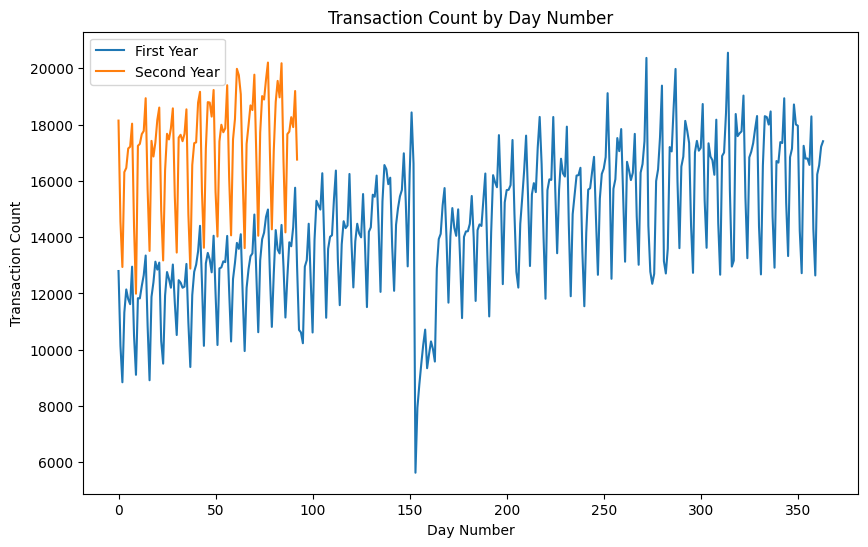

In [15]:
first_year_grouped_by_day = grouped_by_day.iloc[:364]
second_year_grouped_by_day = grouped_by_day.iloc[364:]
second_year_grouped_by_day.index = second_year_grouped_by_day.index - 364


# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(first_year_grouped_by_day.index, first_year_grouped_by_day['amount'], label='First Year')
plt.plot(second_year_grouped_by_day.index, second_year_grouped_by_day['amount'], label='Second Year')

# Adding labels and title
plt.xlabel('Day Number')
plt.ylabel('Transaction Count')
plt.title('Transaction Count by Day Number')
plt.legend()

# Displaying the plot
plt.show()

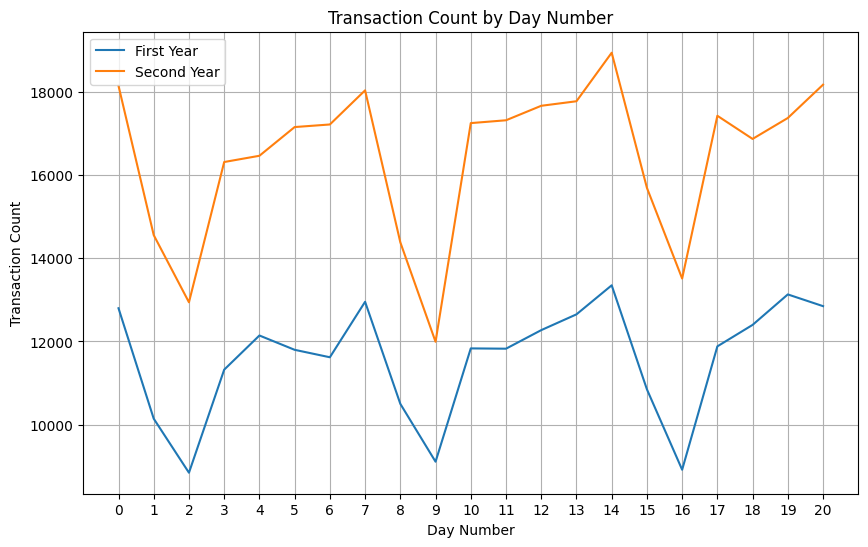

In [17]:
first14days_first_year = first_year_grouped_by_day.iloc[:21]
first14days_second_year = second_year_grouped_by_day.iloc[:21]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(first14days_first_year.index, first14days_first_year['amount'], label='First Year')
plt.plot(first14days_second_year.index, first14days_second_year['amount'], label='Second Year')

# Adding labels and title
plt.xlabel('Day Number')
plt.ylabel('Transaction Count')
plt.title('Transaction Count by Day Number')
plt.legend()

# Show each number on the x-axis
plt.xticks(first14days_first_year.index)

# Add grid
plt.grid(True)

# Displaying the plot
plt.show()

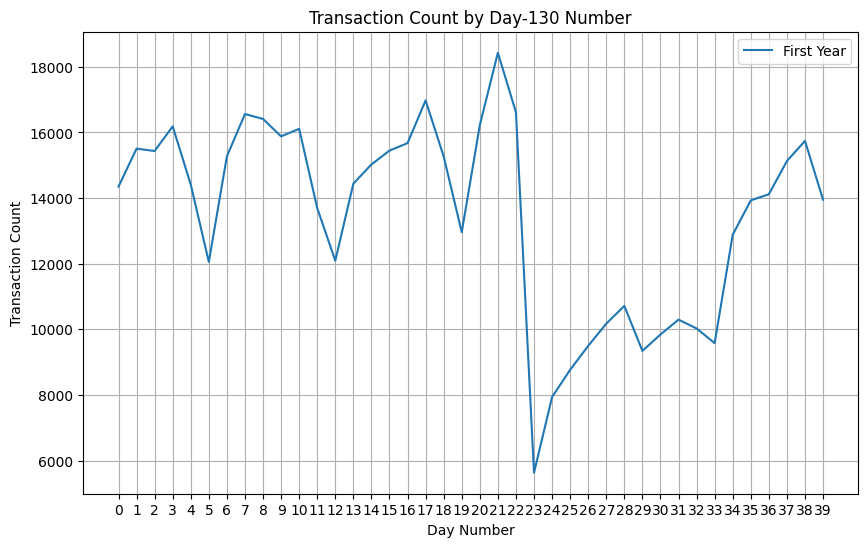

In [16]:
first_year_anomaly = first_year_grouped_by_day.iloc[130:170]
first_year_anomaly.index = first_year_anomaly.index - 130

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(first_year_anomaly.index, first_year_anomaly['amount'], label='First Year')

# Adding labels and title
plt.xlabel('Day Number')
plt.ylabel('Transaction Count')
plt.title('Transaction Count by Day-130 Number')
plt.legend()

# Show each number on the x-axis
plt.xticks(first_year_anomaly.index)

# Add grid
plt.grid(True)

# Displaying the plot
plt.show()

Из графика выше можно предположить, что 153 день - 1 января какого-то года.
Из другого предположения - 153 день - четверг
2014 - 2015 

Задание 2. Декодировать суммы поступлений и списаний. 

Подсказка: сумма транзакции в условных единицах (amount) получена из реальной суммы транзакции умноженной на некий "секретный" коэффициент. 


In [71]:
transaction_df[transaction_df['tr_type'] == 2010].sort_values(by='amount', ascending=False)


,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day_number
5039933,89808284,318 01:23:12,6011,2010,786070.52,80464,318
5039930,89808284,318 01:23:25,6011,2010,786070.52,80464,318
4211047,66358761,349 00:00:00,6011,2010,399773.01,10042243,349
1732778,53194608,78 14:30:38,6011,2010,336887.37,NaN,78
89147,59412639,99 11:30:52,6011,2010,224591.58,NaN,99
...,...,...,...,...,...,...,...
4674467,95303296,389 10:05:26,6011,2010,-4491831.54,10075982,389
1087471,76310395,418 13:26:12,6011,2010,-4491831.54,645588,418
3899803,45890327,441 15:39:40,6011,2010,-4491831.54,381919,441
5245301,47577577,382 20:07:35,6011,2010,-4491831.54,551637,382


In [70]:
transaction_df[transaction_df['tr_type'] == 2010].groupby('amount').agg({'amount': 'count'}).rename(columns={'amount': 'count'}).sort_values(by='count', ascending=False).head(10)

,count
amount,
-22459.16,114203
-11229.58,106935
-44918.32,78444
-67377.47,63183
-89836.63,47912
-8983.66,44379
-4491.83,39590
-112295.79,39403
-6737.75,38868


Коэффициент равен: 22.45916

Задание 3. Соотнести 0 и 1 к полу

In [14]:
people_df = pd.read_csv('../data/gender_train.csv')
cosmetics_df = transaction_df[transaction_df['mcc_code'] == 5977]
cosm_people_df = people_df[people_df['customer_id'].isin(cosmetics_df['customer_id'].unique())]
cosm_people_df

,customer_id,gender
0,10928546,1
8,82609845,0
9,60046355,1
11,83715039,0
12,67193294,0
...,...,...
8383,94098171,0
8385,99100618,0
8387,18780719,0
8393,75028202,1


In [22]:
clothes_wom_df = transaction_df[transaction_df['mcc_code'] == 5621]
clothes_people_df = people_df[people_df['customer_id'].isin(clothes_wom_df['customer_id'].unique())]

accessories_df = transaction_df[transaction_df['mcc_code'] == 5631]
accessories_people_df = people_df[people_df['customer_id'].isin(accessories_df['customer_id'].unique())]


In [ ]:
print(cosm_people_df.groupby("gender").aggregate("count"))
print(clothes_people_df.groupby("gender").aggregate("count"))
print(accessories_people_df.groupby("gender").aggregate("count"))

        customer_id
gender             
0              2294
1              1111
        customer_id
gender             
0              1297
1               424
        customer_id
gender             
0               664
1               205


Исходя из ячейки выше, мы можем сделать однозначный выбор, что 0 - соответствует женскому полу, а 1 - мужскому полу.